# Training 2D CNN on Maize transcriptome data

This file is part of the Comparative analysis of tissue-specific genes in maize based on machine learning models: CNN performs technically best, LightGBM performs biologically sound project.

### Objective:
> Investigation into 2D CNN with Maize transcriptome data

### Input files:
1. *Filtered_Maize_expression.csv*


### Output files:
1. *{data_type}_model_topology.json*
2. *{data_type}_model_weights.hdf5*
 
### Table of contents:
1. [Import Modules](#1.-Import-Modules)  
2. [Set static paths](#2.-Set-static-paths)  
3. [Process data](#4.-Process-data)  
    3.1 [Split X and y](#4.1-Split-X-and-y)  
    3.2 [Transform data](#4.2-Transform-data)  
    3.3 [Add labels](#4.3-Add-labels)
4. [Train model](#5.-Train-model)  
    4.1 [Fit model](#5.1-Fit-model)  
    4.2 [Save model](#5.2-Save-model)  
5. [Test model](#6.-Test-model)  
    4.1 [Prepare data](#6.2-Prepare-data)  
    4.2 [Load model](#6.3-Load-model)  
    4.3 [Run inference](#6.4-Run-inference)  

## 1. Import Modules

In [27]:
import pandas as pd
import numpy as np
import pickle

In [28]:
import os
util_path = '../notebooks'
os.chdir(util_path)
Expression_matrix = pd.read_csv('2Filtered_Maize_expression.csv', index_col=0)

In [29]:
Expression_matrix.head()

,Zm00001d032396,Zm00001d032398,Zm00001d032399,Zm00001d032400,Zm00001d032401,Zm00001d032402,Zm00001d032405,Zm00001d032407,Zm00001d032408,Zm00001d032409,...,Zm00001d045391,Zm00001d045361,Zm00001d045063,Zm00001d045054,Zm00001d045015,Zm00001d044966,Zm00001d046033,Zm00001d046016,Zm00001d047658,tissue
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
SRR1030974,8.157619,0.0,2.275141,52.605335,0.514260,58.711246,47.712910,14.526341,0.591568,7.529287,...,2.773152,5.296510,3.277321,0.298473,2.080474,5.034541,6.040693,42.783398,0.196235,root
SRR1030975,7.264478,0.0,2.779206,57.824116,0.559446,52.145851,82.328278,13.596546,0.364540,3.799316,...,6.606791,4.113046,1.851271,0.261718,2.769382,5.007706,5.638885,41.406376,0.000000,root
SRR1030976,8.328547,0.0,3.230831,42.953331,0.334829,49.397705,49.869648,8.037382,0.405711,6.947237,...,38.602425,2.604917,4.993490,1.731227,2.359700,2.586420,6.572925,51.332336,0.109857,root
SRR1030977,6.621617,0.0,2.838485,65.223167,1.483768,53.151070,75.148918,14.176978,0.790322,3.839634,...,4.471345,10.553447,1.957708,0.029638,2.777192,4.330374,5.348520,40.181637,0.022587,root
SRR1030978,8.687157,0.0,2.788881,52.362190,0.346632,46.062824,51.403378,8.094249,0.510341,6.406972,...,111.361015,3.941180,5.267010,1.550525,2.630184,3.084651,6.505562,50.188221,0.217275,root


In [30]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(Expression_matrix,test_size = 0.2)

In [31]:
util_path = '../src'
os.chdir(util_path)

In [32]:
from keras import backend as K
from keras.models import model_from_json
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score

In [33]:
from modelling.cnn import convert_2d, convert_onehot, keras_cnn, log_transform
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Select a single GPU to use 
# Skip this part if you're parallelising or only have 1 GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"; 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 2. Set static paths

In [35]:
data_type = "imbalanced"

In [36]:
input_dir = "../data/processed/"
model_dir = "../models/"
fig_dir = "../figures/"

## 3. Process data

#### 3.1 Split X and y

In [38]:
X = train.drop('tissue', axis=1)
y_train = train['tissue']

#### 3.2 Transform data

In [39]:
X_train = log_transform(X)

In [40]:
X_train_converted = convert_2d(X_train)
y_train_converted = convert_onehot(y_train)

## 4. Train model

#### 4.1 Fit model

In [41]:
model = keras_cnn(X_train_converted, y_train_converted)
print("Model Initiated.")

Model Initiated.


In [42]:
# Train model beautifully
history = model.fit(
    X_train_converted, 
    y_train_converted, 
    batch_size=64, 
    epochs=50,
    verbose=1,
    validation_split=0.1, 
)

Train on 687 samples, validate on 77 samples
Epoch 1/50
687/687 [==============================] - 5s 7ms/step - loss: 0.8301 - accuracy: 0.7933 - val_loss: 8.2766 - val_accuracy: 0.2208
Epoch 2/50
687/687 [==============================] - 4s 5ms/step - loss: 0.1505 - accuracy: 0.9607 - val_loss: 2.9158 - val_accuracy: 0.2208
Epoch 3/50
687/687 [==============================] - 4s 5ms/step - loss: 0.0510 - accuracy: 0.9898 - val_loss: 1.9444 - val_accuracy: 0.5065
Epoch 4/50
687/687 [==============================] - 4s 5ms/step - loss: 0.0183 - accuracy: 0.9956 - val_loss: 1.9443 - val_accuracy: 0.4935
Epoch 5/50
687/687 [==============================] - 4s 5ms/step - loss: 0.0175 - accuracy: 0.9942 - val_loss: 2.0358 - val_accuracy: 0.4935
Epoch 6/50
687/687 [==============================] - 4s 5ms/step - loss: 0.0064 - accuracy: 0.9971 - val_loss: 2.5067 - val_accuracy: 0.2987
Epoch 7/50
687/687 [==============================] - 4s 5ms/step - loss: 0.0072 - accuracy: 0.9971 - v

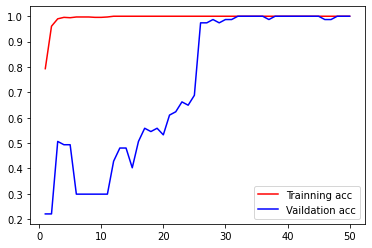

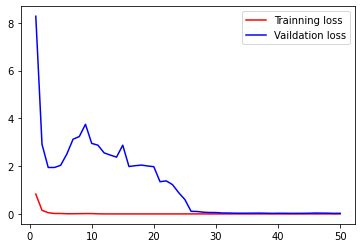

In [43]:
#Figures of accuracy and loss
import matplotlib.pyplot as plt
acc = history.history['accuracy']    
val_acc = history.history['val_accuracy']    
loss = history.history['loss']          
val_loss = history.history['val_loss']  
epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'r',label='Trainning acc')     
plt.plot(epochs,val_acc,'b',label='Vaildation acc') 
plt.legend()  

file_path = fig_dir+"acc.svg"
plt.savefig(file_path)

plt.figure()  
plt.plot(epochs,loss,'r',label='Trainning loss')
plt.plot(epochs,val_loss,'b',label='Vaildation loss')
plt.legend()  

file_path = fig_dir+"loss.svg"
plt.savefig(file_path)

plt.show()    

#### 4.2 Save model

In [44]:
# Save model JSON and weights
model_json = model.to_json()
with open(model_dir+f"{data_type}_model_topology.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights(model_dir+f"{data_type}_model_weights.hdf5")

In [45]:
# Delete model after training
K.clear_session()
del model

## 5. Test model

#### 5.1 Prepare data

In [47]:
X_test = test.drop('tissue', axis=1)
y_test = test['tissue']


X_test = log_transform(X_test)
X_test = convert_2d(X_test)

lb = LabelBinarizer()
lb.fit(y_test.values)

LabelBinarizer()

#### 5.2 Load model

In [48]:
# Load model beatifully
model_json_path = model_dir+f"{data_type}_model_topology.json"
trained_model = model_from_json(
    open(model_json_path, "r").read()
)

# load weights into new model
model_weights_path = model_dir+f"{data_type}_model_weights.hdf5"
trained_model.load_weights(model_weights_path)

#### 5.3 Run inference

In [49]:
# Run predictions and add everything to a giant DataFrame
y_preds = trained_model.predict_classes(
    X_test
)

num_preds = len(y_preds)

classes = test['tissue'].unique()
num_classes = len(classes)

y_preds_onehot = np.zeros([num_preds, num_classes])
y_preds_onehot[np.arange(num_preds), y_preds] = 1

y_preds_labels = lb.inverse_transform(y_preds_onehot)

print(
    f"macro-average F1 : {f1_score(y_test, y_preds_labels, average='macro')}"
)

macro-average F1 : 0.9102737780807133
